# This notebook shows the process from collecting data, to finding the best model for Formula One prediction

The objective here is to obtain a data representing the full grand Prix week end, for every drivers.
Now we have those informations in the data depending on the session name. 
In  our case we need to have them in the same row.

Summary : Gather all prediction models attempts, correlation and models performance graphs
1) “allData.csv” preparation for AI 2)  Training, pruning and best model selection 3)  Result analysis

### Import the data and the tools

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
data = pd.read_csv(r'..\Data\allData.csv')

## Checking the data

In [3]:
data.shape

(6625, 25)

In [4]:
data.columns

Index(['number', 'position', 'Q1', 'Q2', 'Q3', 'positionText', 'points',
       'grid', 'laps', 'status', 'year', 'gpName', 'gpNumber', 'sessionName',
       'driverId', 'code', 'DriverNationality', 'constructorId',
       'constructorNationality', 'fastestLapNumber', 'fastestLapRank',
       'fastestLapAvgSpeed', 'fastestLapTime', 'totalTime', 'TimeInterval'],
      dtype='object')

In [5]:
data.describe()

,number,position,points,grid,laps,year,gpNumber,fastestLapNumber,fastestLapRank,fastestLapAvgSpeed,totalTime
count,6625.000000,6625.000000,1619.000000,1619.000000,1619.000000,6625.000000,6625.000000,4935.000000,4935.000000,1546.000000,7.960000e+02
mean,28.059925,10.479547,5.066399,10.155652,54.329216,2019.506113,10.544906,23.296251,10.382776,210.685937,5.697824e+06
std,25.708990,5.757025,7.218282,5.818685,17.921190,1.147093,5.960681,18.526019,5.711727,19.654407,1.287765e+06
min,2.000000,1.000000,0.000000,0.000000,0.000000,2018.000000,1.000000,2.000000,1.000000,140.802000,2.070710e+05
25%,8.000000,5.000000,0.000000,5.000000,52.000000,2018.000000,5.000000,10.000000,5.000000,200.297250,5.282710e+06
50%,18.000000,10.000000,1.000000,10.000000,56.000000,2019.000000,10.000000,14.000000,10.000000,210.106500,5.596877e+06
75%,44.000000,15.000000,8.000000,15.000000,67.000000,2021.000000,16.000000,37.000000,15.000000,224.515500,5.948403e+06
max,99.000000,20.000000,27.000000,20.000000,87.000000,2021.000000,22.000000,85.000000,20.000000,255.014000,1.081032e+07


## Spliting the data into the practice, the race and qualifying 

 The goal of this step is to be able to merge the data to obtain a good data structure for processing

In [6]:
df_race = data[data['sessionName'] == 'Race']

In [7]:
df_practice1 = data[data['sessionName'] == 'Practice 1'][['fastestLapRank','fastestLapTime','year','gpName','driverId']]

In [8]:
df_practice2 = data[data['sessionName'] == 'Practice 2'][['fastestLapRank','fastestLapTime','year','gpName','driverId']]

In [9]:
df_practice3 = data[data['sessionName'] == 'Practice 3'][['fastestLapRank','fastestLapTime','year','gpName','driverId']]

In [10]:
df_practice1 = df_practice1.rename(columns={"fastestLapRank": "fastestLapRankP1","fastestLapTime": "fastestLapTimeP1"})
df_practice2 = df_practice2.rename(columns={"fastestLapRank": "fastestLapRankP2","fastestLapTime": "fastestLapTimeP2"})
df_practice3 = df_practice3.rename(columns={"fastestLapRank": "fastestLapRankP3","fastestLapTime": "fastestLapTimeP3"})

In [11]:
df_quali = data[data['sessionName'] == 'Qualifying'][['Q1','Q2','Q3','year','gpName','driverId']]

#### Data manipulation on race and qualifying to merge them 

In [12]:
df_race.isna().sum()

number                       0
position                     0
Q1                        1619
Q2                        1619
Q3                        1619
positionText                 0
points                       0
grid                         0
laps                         0
status                       0
year                         0
gpName                       0
gpNumber                     0
sessionName                  0
driverId                     0
code                         0
DriverNationality            0
constructorId                0
constructorNationality       0
fastestLapNumber            73
fastestLapRank              73
fastestLapAvgSpeed          73
fastestLapTime              73
totalTime                  823
TimeInterval               823
dtype: int64

In [13]:
df_race = df_race.drop(['Q1','Q2','Q3'], axis=1)

In [14]:
df_race['totalTime'].describe()

count    7.960000e+02
mean     5.697824e+06
std      1.287765e+06
min      2.070710e+05
25%      5.282710e+06
50%      5.596877e+06
75%      5.948403e+06
max      1.081032e+07
Name: totalTime, dtype: float64

In [15]:
df_race['totalTime'] = df_race['totalTime'].fillna(df_race['totalTime'].max())

In [16]:
df_race.isna().sum()

number                      0
position                    0
positionText                0
points                      0
grid                        0
laps                        0
status                      0
year                        0
gpName                      0
gpNumber                    0
sessionName                 0
driverId                    0
code                        0
DriverNationality           0
constructorId               0
constructorNationality      0
fastestLapNumber           73
fastestLapRank             73
fastestLapAvgSpeed         73
fastestLapTime             73
totalTime                   0
TimeInterval              823
dtype: int64

first step of our data creation, the race is combined to the qualifying for each drivers 

In [17]:
race_quali = pd.merge(df_race, df_quali, how="left", on=['year','gpName','driverId'])

In [18]:
race_quali.shape 

(1619, 25)

In [19]:
race_quali.columns

Index(['number', 'position', 'positionText', 'points', 'grid', 'laps',
       'status', 'year', 'gpName', 'gpNumber', 'sessionName', 'driverId',
       'code', 'DriverNationality', 'constructorId', 'constructorNationality',
       'fastestLapNumber', 'fastestLapRank', 'fastestLapAvgSpeed',
       'fastestLapTime', 'totalTime', 'TimeInterval', 'Q1', 'Q2', 'Q3'],
      dtype='object')

Second step is to combined the practices data with 

In [20]:
race_quali_1 = pd.merge(race_quali, df_practice1, how="left", on=['year','gpName','driverId'])

In [21]:
race_quali_12 = pd.merge(race_quali_1, df_practice2, how="left", on=['year','gpName','driverId'])

In [22]:
data_complete = pd.merge(race_quali_12, df_practice3, how="left", on=['year','gpName','driverId'])

In [23]:
data_complete.columns

Index(['number', 'position', 'positionText', 'points', 'grid', 'laps',
       'status', 'year', 'gpName', 'gpNumber', 'sessionName', 'driverId',
       'code', 'DriverNationality', 'constructorId', 'constructorNationality',
       'fastestLapNumber', 'fastestLapRank', 'fastestLapAvgSpeed',
       'fastestLapTime', 'totalTime', 'TimeInterval', 'Q1', 'Q2', 'Q3',
       'fastestLapRankP1', 'fastestLapTimeP1', 'fastestLapRankP2',
       'fastestLapTimeP2', 'fastestLapRankP3', 'fastestLapTimeP3'],
      dtype='object')

In [24]:
data_complete.shape

(1619, 31)

We have now finaly a data that represent the entire week end (Grand prix) for a driver 

# Now we have to make the data suitable for the predictions  

We want to predict the position of a driver before the race but after the practices sessions and the qualifying. 
To do so we have to predict the variable " Position ". 
To avoid biased predictions, we have to drop the variables that are calculated after the race.
We will also drop the variables that are representing the same information ( number, code, driverID represente the same information).

In [25]:
df_pred_postion = data_complete.drop(['positionText','points','laps','status','fastestLapNumber', 'fastestLapRank', 'fastestLapAvgSpeed',
       'fastestLapTime', 'totalTime', 'TimeInterval','code','driverId','sessionName'], axis=1)

In [26]:
df_pred_postion.shape

(1619, 18)

In [27]:
df_pred_postion.isna().sum()

number                      0
position                    0
grid                        0
year                        0
gpName                      0
gpNumber                    0
DriverNationality           0
constructorId               0
constructorNationality      0
Q1                         26
Q2                        434
Q3                        828
fastestLapRankP1          880
fastestLapTimeP1          880
fastestLapRankP2          207
fastestLapTimeP2          207
fastestLapRankP3          381
fastestLapTimeP3          381
dtype: int64

## Dealing with NaN values and conversion

In [28]:
df_pred_postion['fastestLapTimeP3'].describe()

count                       1238
unique                      1222
top       0 days 00:01:05.228000
freq                           2
Name: fastestLapTimeP3, dtype: object

In [29]:
def timeStrToInt(df,columnName):
    l = []
    is_na = df[columnName].isna()
    for i in range(len(df[columnName])):
        is_nai = is_na[i]
        if  is_nai == False :
            value = df[columnName][i]
            if type(value) == np.int64:
                l.append(value)
            else:
                a = value.split(':')
                b = list(map(float,a[1:]))
                l.append(int((b[0]*60*1000 + b[1])*1000))
        else:
            l.append(58276750)
    df[columnName] = l

In [30]:
timeStrToInt(df_pred_postion,'fastestLapTimeP1')
timeStrToInt(df_pred_postion,'fastestLapTimeP2')
timeStrToInt(df_pred_postion,'fastestLapTimeP3')

In [31]:
df_pred_postion['fastestLapTimeP1'].describe()

count    1.619000e+03
mean     5.829842e+07
std      6.734991e+06
min      1.794000e+03
25%      5.827675e+07
50%      5.827675e+07
75%      6.002710e+07
max      6.004926e+07
Name: fastestLapTimeP1, dtype: float64

In [32]:
df_pred_postion.isna().sum()

number                      0
position                    0
grid                        0
year                        0
gpName                      0
gpNumber                    0
DriverNationality           0
constructorId               0
constructorNationality      0
Q1                         26
Q2                        434
Q3                        828
fastestLapRankP1          880
fastestLapTimeP1            0
fastestLapRankP2          207
fastestLapTimeP2            0
fastestLapRankP3          381
fastestLapTimeP3            0
dtype: int64

Q1 Q2 and Q3 must have normaly NaN values, because the drivers are qualified or not to the next Q.
In order to deal with that, we'll put the time of the precedent Q in the one missing.

In [33]:
df_pred_postion[df_pred_postion['Q1'].isna()].head()

,number,position,grid,year,gpName,gpNumber,DriverNationality,constructorId,constructorNationality,Q1,Q2,Q3,fastestLapRankP1,fastestLapTimeP1,fastestLapRankP2,fastestLapTimeP2,fastestLapRankP3,fastestLapTimeP3
74,8,15,20.0,2018,Azerbaijan Grand Prix,4,French,haas,American,NaN,NaN,NaN,14.0,60046856,13.0,60044425,15.0,60045261
91,28,12,20.0,2018,Spanish Grand Prix,5,New Zealander,toro_rosso,Italian,NaN,NaN,NaN,NaN,58276750,18.0,60021265,17.0,60019428
108,33,9,20.0,2018,Monaco Grand Prix,6,Dutch,red_bull,Austrian,NaN,NaN,NaN,3.0,60012280,2.0,60012035,2.0,60011787
131,8,12,20.0,2018,Canadian Grand Prix,7,French,haas,American,NaN,NaN,NaN,NaN,58276750,7.0,60013620,9.0,60013014
191,18,12,19.0,2018,British Grand Prix,10,Canadian,williams,British,NaN,NaN,NaN,10.0,60029878,NaN,58276750,NaN,58276750


In [34]:
def timeStrToIntQ1(df):
    l = []
    is_na = df['Q1'].isna()
    for i in range(len(df['Q1'])):
        is_nai = is_na[i]
        if  is_nai == False :
            value = df['Q1'][i]
            if type(value) == np.int64:
                l.append(value)
            else:
                a = value.split(':')
                b = list(map(float,a))
                l.append(int((b[0]*60*1000 + b[1])*1000))
        else:
            l.append(120004382)
    df['Q1'] = l

def timeStrToIntQ2_3(df, Q_number):
    l = []
    Q = 'Q'+str(Q_number)
    is_na = df[Q].isna()
    for i in range(len(df[Q])):
        is_nai = is_na[i]
        if  is_nai == False :
            value = df[Q][i]
            if type(value) == np.int64:
                l.append(value)
            else:
                a = value.split(':')
                b = list(map(float,a))
                l.append(int((b[0]*60*1000 + b[1])*1000))
        else:
            c_name = 'Q'+ str((Q_number-1))
            l.append(df[c_name].iloc[i])
    df[Q] = l


In [35]:
timeStrToIntQ1(df_pred_postion)
timeStrToIntQ2_3(df_pred_postion,2)
timeStrToIntQ2_3(df_pred_postion,3)

In [36]:
df_pred_postion = df_pred_postion.dropna(subset=['position'])

Now we have to take care of the laps rank, because we don't have the data,
we presume it is because the drivers did not compete 
on those practices sessions. So their ranks are after the last one possible : 21 

In [37]:
df_pred_postion.loc[df_pred_postion.fastestLapRankP1.isna(), 'fastestLapRankP1'] = 10
df_pred_postion.loc[df_pred_postion.fastestLapRankP2.isna(), 'fastestLapRankP2'] = 10
df_pred_postion.loc[df_pred_postion.fastestLapRankP3.isna(), 'fastestLapRankP3'] = 10

In [38]:
df_pred_postion.isna().sum()

number                    0
position                  0
grid                      0
year                      0
gpName                    0
gpNumber                  0
DriverNationality         0
constructorId             0
constructorNationality    0
Q1                        0
Q2                        0
Q3                        0
fastestLapRankP1          0
fastestLapTimeP1          0
fastestLapRankP2          0
fastestLapTimeP2          0
fastestLapRankP3          0
fastestLapTimeP3          0
dtype: int64

we have noticed that when the driver can't do the Qualifying, it can happen that the driver will have a grid of 0
In real life, they start the grand prix from the pit line, we'll assume that the pit line is the position 21 on the grid.
To have logique grid data we need to have that : 

In [39]:
df_pred_postion.loc[df_pred_postion.grid == 0.0, 'grid'] = 21.0

## data homogenization

Now we have to change the format of some variables to make sure that the classifiers support the data 

In [40]:
df_pred_postion.columns

Index(['number', 'position', 'grid', 'year', 'gpName', 'gpNumber',
       'DriverNationality', 'constructorId', 'constructorNationality', 'Q1',
       'Q2', 'Q3', 'fastestLapRankP1', 'fastestLapTimeP1', 'fastestLapRankP2',
       'fastestLapTimeP2', 'fastestLapRankP3', 'fastestLapTimeP3'],
      dtype='object')

In [41]:
df_features = pd.get_dummies(df_pred_postion, columns = [ 'gpName',
       'DriverNationality', 'constructorId', 'constructorNationality'])

## Scale data 

In [42]:
from sklearn.preprocessing import MinMaxScaler

In [43]:
scaler = MinMaxScaler()
to_scale = ['Q1','Q2', 'Q3','fastestLapTimeP1',
       'fastestLapTimeP2', 'fastestLapTimeP3']
df_scaled = df_features.copy()
df_scaled[to_scale] = scaler.fit_transform(df_scaled[to_scale].to_numpy())
df_scaled.head()

,number,position,grid,year,gpNumber,Q1,Q2,Q3,fastestLapRankP1,fastestLapTimeP1,...,constructorId_toro_rosso,constructorId_williams,constructorNationality_American,constructorNationality_Austrian,constructorNationality_British,constructorNationality_French,constructorNationality_German,constructorNationality_Indian,constructorNationality_Italian,constructorNationality_Swiss
0,5,1,3.0,2018,1,0.499880,0.499869,0.499869,5.0,0.999596,...,0,0,0,0,0,0,0,0,1,0
1,44,2,1.0,2018,1,0.499876,0.499870,0.499864,1.0,0.999580,...,0,0,0,0,0,0,1,0,0,0
2,7,3,2.0,2018,1,0.499878,0.499874,0.499869,4.0,0.999594,...,0,0,0,0,0,0,0,0,1,0
3,3,4,8.0,2018,1,0.499881,0.499877,0.499872,6.0,0.999597,...,0,0,0,1,0,0,0,0,0,0
4,14,5,10.0,2018,1,0.499882,0.499884,0.499885,8.0,0.999611,...,0,0,0,0,1,0,0,0,0,0


In [44]:
df_scaled = pd.DataFrame(df_scaled, columns= df_features.columns)

## Prediction models with scaled Data 

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import svm
from sklearn.neural_network import MLPClassifier

In [46]:
def error_calculation(error):
    round_error = round(error)
    mape = 100 * (error / y_test)
    count = 0
    for elmt in round_error:
        if elmt==0:
            count+=1
    print('Mean Absolute Error:', round(np.mean(error), 2))
    print('Mean Absolute Percentage Error :', round(np.mean(mape), 2), '%.')
    print('Accuracy :',count/len(round_error)*100, '%.')       
   

In [47]:
def error_calculationNoDisplay(error):
    round_error = round(error)
    mape = 100 * (error / y_test)
    count = 0
    for elmt in round_error:
        if elmt==0:
            count+=1
    return [round(np.mean(error), 2),round(np.mean(mape), 2),count/len(round_error)*100]

In [48]:
def evaluate(model, test_features, test_labels,display=True):
    y_pred = model.predict(test_features) 
    error = abs(y_pred - test_labels)
    error_calculation(error)
    return y_pred

In [49]:
def evaluateNoDisplay(model, test_features, test_labels,display=True):
    y_pred = model.predict(test_features) 
    error = abs(y_pred - test_labels)
    return y_pred,error_calculationNoDisplay(error)

In [50]:
def test_train_creation(df):
    train, test = train_test_split(df, test_size=0.2)
    X_train = train.drop(['position'], axis=1)
    y_train = train['position']
    X_test = test.drop(['position'], axis=1)
    y_test = test['position']
    return X_train,y_train,X_test,y_test

Dictionnary to save the accuracy of the different models

In [51]:
accuracy_pred = {}

### We try a Random forest 

In [52]:
X_train,y_train,X_test,y_test = test_train_creation(df_scaled)

In [53]:
random_forest = RandomForestRegressor() 
model_rd = random_forest.fit(X_train, y_train)
model_rd.score(X_train,y_train)

0.9125210913929984

In [54]:
y_pred = evaluate(random_forest, X_test, y_test)

Mean Absolute Error: 3.48
Mean Absolute Percentage Error : 57.94 %.
Accuracy : 10.185185185185185 %.


Text(0.5, 0, 'Relative Importance')

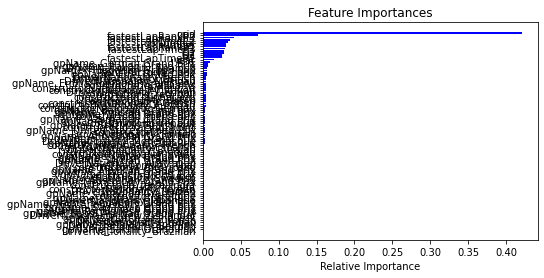

In [55]:
importances = model_rd.feature_importances_
indices = np.argsort(importances)
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_test.columns[i] for i in indices])
plt.xlabel('Relative Importance')

We can see from this graph that most of the features like the nationality ones are note usefull at all. 5 we'll drop those columns later, after the comparison with the not scaled data

In [56]:
[X_test.columns[i] for i in indices][-15:]

['gpName_Italian Grand Prix',
 'gpName_German Grand Prix',
 'year',
 'fastestLapTimeP1',
 'Q3',
 'Q2',
 'Q1',
 'fastestLapTimeP3',
 'fastestLapRankP1',
 'number',
 'gpNumber',
 'fastestLapTimeP2',
 'fastestLapRankP3',
 'fastestLapRankP2',
 'grid']

## Searching a good regression algorithm ,Not scaled data ( to compare )

In [57]:
X_train,y_train,X_test,y_test = test_train_creation(df_features)

In [58]:
model_lm = LinearRegression()
model_lm.fit(X_train, y_train)
print('Score on train data:',model_lm.score(X_train, y_train))
y_pred = evaluate(model_lm, X_test, y_test)
accuracy_pred['LinearRegression']= evaluateNoDisplay(model_lm, X_test, y_test)

Score on train data: 0.47826355447378244
Mean Absolute Error: 3.41
Mean Absolute Percentage Error : 63.09 %.
Accuracy : 8.641975308641975 %.


In [59]:
random_forest = RandomForestRegressor() 
model_rd = random_forest.fit(X_train, y_train)
print('Score on train data:',model_rd.score(X_train, y_train))
y_pred = evaluate(random_forest, X_test, y_test)
accuracy_pred['RandomForestRegressor']= evaluateNoDisplay(random_forest, X_test, y_test)

Score on train data: 0.915223589699527
Mean Absolute Error: 3.5
Mean Absolute Percentage Error : 65.27 %.
Accuracy : 10.802469135802468 %.


In [60]:
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
y_pred = lda.fit(X_train, y_train).predict(X_test)
print('Score on train data:',lda.score(X_train, y_train))
y_pred = evaluate(lda, X_test, y_test)
accuracy_pred['LDA']= evaluateNoDisplay(lda, X_test, y_test)

Score on train data: 0.24324324324324326
Mean Absolute Error: 3.95
Mean Absolute Percentage Error : 45.9 %.
Accuracy : 9.876543209876543 %.


In [61]:
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
y_pred = qda.fit(X_train, y_train).predict(X_test)
print('Score on train data:',qda.score(X_train, y_train))
y_pred = evaluate(qda, X_test, y_test)
accuracy_pred['QDA']= evaluateNoDisplay(qda, X_test, y_test)

Score on train data: 0.8355212355212355
Mean Absolute Error: 4.69
Mean Absolute Percentage Error : 56.61 %.
Accuracy : 6.790123456790123 %.


C:\Users\benja\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [62]:
clf = MLPClassifier()
clf.fit(X_train, y_train)
print('Score on train data:',clf.score(X_train, y_train))
y_pred = evaluate(clf, X_test, y_test)
accuracy_pred['MLPClassifier']= evaluateNoDisplay(clf, X_test, y_test)

Score on train data: 0.047104247104247106
Mean Absolute Error: 5.21
Mean Absolute Percentage Error : 106.75 %.
Accuracy : 5.864197530864197 %.


The results show that it is ambiguous between scaled or not scaled data we should use. The random forest seems to be the best option.

## Drop useless/non significant columns

In [63]:
df_features2 =  pd.get_dummies(df_pred_postion, columns = ['constructorId'])


In [64]:
df_features2=df_features2.drop(['DriverNationality','constructorNationality','gpName'], axis=1)

In [65]:
df_features2.shape

(1619, 29)

In [66]:
scaler = MinMaxScaler()
to_scale = ['Q1','Q2', 'Q3','fastestLapTimeP1',
       'fastestLapTimeP2', 'fastestLapTimeP3']
df_scaled2 = df_features2.copy()
df_scaled2[to_scale] = scaler.fit_transform(df_scaled2[to_scale].to_numpy())
df_scaled2 = pd.DataFrame(df_scaled2, columns= df_features2.columns)

In [67]:
df_scaled2.columns

Index(['number', 'position', 'grid', 'year', 'gpNumber', 'Q1', 'Q2', 'Q3',
       'fastestLapRankP1', 'fastestLapTimeP1', 'fastestLapRankP2',
       'fastestLapTimeP2', 'fastestLapRankP3', 'fastestLapTimeP3',
       'constructorId_alfa', 'constructorId_alphatauri',
       'constructorId_alpine', 'constructorId_aston_martin',
       'constructorId_ferrari', 'constructorId_force_india',
       'constructorId_haas', 'constructorId_mclaren', 'constructorId_mercedes',
       'constructorId_racing_point', 'constructorId_red_bull',
       'constructorId_renault', 'constructorId_sauber',
       'constructorId_toro_rosso', 'constructorId_williams'],
      dtype='object')

## The data is now trained considering the season and not the previous ones ( exeption for the first GP)

This choice has been made to have a better match with the reality ( we don't have the results of the future GP)

In [68]:
def which_gpV2(gpNumber,year,df,n):
    if year != 2018:
        test,train = None,None
        if (gpNumber-n)<=0:
            gpy_1 = df[df['year']==year-1]['gpNumber'].max()
            idx = df[(df['gpNumber']==(gpNumber)) & (df['year']==year)].index[0]
            idx_begin = df[(df['gpNumber']==(gpy_1+(gpNumber-n))) & (df['year']==(year-1))].index[0]
            idx_end = idx+20
            train = df.iloc[idx_begin:idx]
            test = df.iloc[idx:idx_end]
        else:
            idx = df[(df['gpNumber']==(gpNumber)) & (df['year']==year)].index[0]
            idx_begin = df[df['year']==year].index[0]
            idx_end = idx+20
            train = df.iloc[idx_begin:idx]
            test = df.iloc[idx:idx_end]
    else:
        if gpNumber != 1:
            idx = df[(df['gpNumber']==gpNumber) & (df['year']==year)].index[0]
            idx_begin = df[df['year']==year].index[0]
            idx_end = idx+20
            train = df.iloc[idx_begin:idx]
            test = df.iloc[idx:idx_end]
    return train,test

In [69]:
def which_gp(gpNumber,year,df):
    if gpNumber != 1:
        idx = df[(df['gpNumber']==gpNumber) & (df['year']==year)].index[0]
        idx_begin = df[df['year']==year].index[0]
        idx_end = idx+20
        train = df.iloc[idx_begin:idx]
        test = df.iloc[idx:idx_end]
    else:
        idx = df[(df['gpNumber']==gpNumber) & (df['year']==year)].index[0]
        idx_begin = df[df['year']==(year-1)].index[0]
        idx_end = idx+20
        train = df.iloc[idx_begin:idx]
        test = df.iloc[idx:idx_end]
    return train,test

#### Test without the new data format

In [70]:
X_train,y_train,X_test,y_test = test_train_creation(df_features2)

In [71]:
clf = RandomForestClassifier(max_depth=5, random_state=1)
model_rf = clf.fit(X_train, y_train)
print('Score on train data:',clf.score(X_train, y_train))
y_pred = evaluate(clf, X_test, y_test)

Score on train data: 0.4247104247104247
Mean Absolute Error: 3.37
Mean Absolute Percentage Error : 36.16 %.
Accuracy : 16.358024691358025 %.


#### test with the good data format

In [72]:
def test_train_creation_gp(df,year,gpNumber):
    train, test = which_gp(gpNumber,year,df)
    X_train = train.drop(['position'], axis=1)
    y_train = train['position']
    X_test = test.drop(['position'], axis=1)
    y_test = test['position']
    return X_train,y_train,X_test,y_test
def test_train_creation_gpV2(df,year,gpNumber,n):
    train, test = which_gpV2(gpNumber,year,df,n)
    X_train = train.drop(['position'], axis=1)
    y_train = train['position']
    X_test = test.drop(['position'], axis=1)
    y_test = test['position']
    return X_train,y_train,X_test,y_test

In [73]:
X_train,y_train,X_test,y_test = test_train_creation_gp(df_features2,2021,21)

In [74]:
clf = RandomForestClassifier()
model_rf = clf.fit(X_train, y_train)
print('Score on train data:',clf.score(X_train, y_train))
y_pred = evaluate(clf, X_test, y_test)

Score on train data: 1.0
Mean Absolute Error: 3.7
Mean Absolute Percentage Error : 37.54 %.
Accuracy : 15.0 %.


In [75]:
clf = RandomForestRegressor()
model_rf = clf.fit(X_train, y_train)
print('Score on train data:',clf.score(X_train, y_train))
y_pred = evaluate(clf, X_test, y_test)

Score on train data: 0.9222568345864661
Mean Absolute Error: 3.19
Mean Absolute Percentage Error : 66.55 %.
Accuracy : 10.0 %.


#### We must have have,as a result, a ranking of every driver.

In [76]:
def rank(y_pred):
    y_pred_1 =  sorted(y_pred.copy())
    for i in range(len(y_pred_1)):
        for j in range(len(y_pred)):
            if y_pred_1[i] == y_pred[j]:
                y_pred_1[i] = j+1
    return y_pred_1

In [77]:
def evaluaterank(test_labels,y_pred):
    y_pred = rank(y_pred)
    error = abs(y_pred - test_labels)
    error_calculation(error)
    return y_pred

In [78]:
def evaluaterankNoDisplay(test_labels,y_pred):
    y_pred = rank(y_pred)
    error = abs(y_pred - test_labels)
    return y_pred,error_calculationNoDisplay(error)

In [79]:
y_pred_reg = evaluaterank(y_test,y_pred)
y_pred_reg = evaluaterankNoDisplay(y_test,y_pred)
y_pred_reg

Mean Absolute Error: 2.7
Mean Absolute Percentage Error : 40.14 %.
Accuracy : 25.0 %.


([2, 3, 7, 1, 6, 17, 4, 8, 9, 10, 5, 15, 13, 14, 16, 19, 11, 20, 12, 18],
 [2.7, 40.14, 25.0])

## Finding the best classification algorithm with scaled data

In [80]:
X_train,y_train,X_test,y_test = test_train_creation_gp(df_scaled2,2019,10)

In [81]:
random_forest = RandomForestClassifier() 
model_rd = random_forest.fit(X_train, y_train)
print('Score on train data:',random_forest.score(X_train, y_train))
y_pred = evaluate(random_forest, X_test, y_test)
accuracy_pred['RFClf']= evaluateNoDisplay(random_forest, X_test, y_test)

Score on train data: 1.0
Mean Absolute Error: 2.65
Mean Absolute Percentage Error : 21.68 %.
Accuracy : 20.0 %.


Text(0.5, 0, 'Relative Importance')

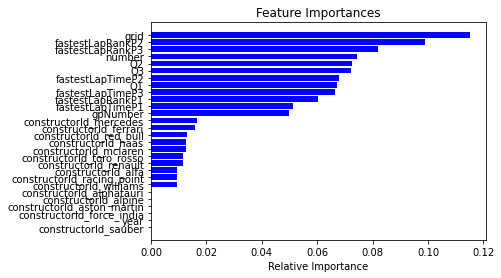

In [82]:
importances = model_rd.feature_importances_
indices = np.argsort(importances)
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_test.columns[i] for i in indices])
plt.xlabel('Relative Importance')

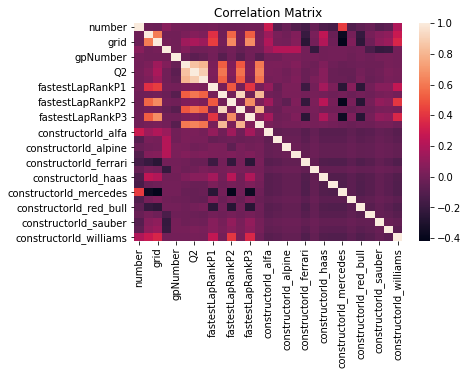

In [83]:
corrMatrix = df_scaled2.corr()
sns.heatmap(corrMatrix)
plt.title('Correlation Matrix')
plt.show()

In [84]:
model_svm = svm.LinearSVC()
model_svm.fit(X_train, y_train)
print('Score on train data:',random_forest.score(X_train, y_train))
y_pred = evaluate(model_svm, X_test, y_test)
accuracy_pred['svm.LinearSVC']= evaluateNoDisplay(model_svm, X_test, y_test)

Score on train data: 1.0
Mean Absolute Error: 6.5
Mean Absolute Percentage Error : 193.1 %.
Accuracy : 5.0 %.


C:\Users\benja\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [85]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
print('Score on train data:',knn.score(X_train, y_train))
y_pred = evaluate(knn, X_test, y_test)
accuracy_pred['knn']= evaluateNoDisplay(knn, X_test, y_test)

Score on train data: 0.39444444444444443
Mean Absolute Error: 2.75
Mean Absolute Percentage Error : 20.24 %.
Accuracy : 30.0 %.


In [86]:
log_Reg = LogisticRegression()
log_Reg.fit(X_train, y_train)
print('Score on train data:',log_Reg.score(X_train, y_train))
y_pred = evaluate(log_Reg, X_test, y_test)
accuracy_pred['Log_reg']= evaluateNoDisplay(log_Reg, X_test, y_test)

Score on train data: 0.26666666666666666
Mean Absolute Error: 3.55
Mean Absolute Percentage Error : 41.33 %.
Accuracy : 10.0 %.


C:\Users\benja\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [87]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
print('Score on train data:',clf.score(X_train, y_train))
y_pred = evaluate(clf, X_test, y_test)
accuracy_pred['GradientBoostClf']= evaluateNoDisplay(clf, X_test, y_test)                           

Score on train data: 1.0
Mean Absolute Error: 3.6
Mean Absolute Percentage Error : 34.82 %.
Accuracy : 25.0 %.


## Choice of the good model

In [88]:
label_ = [x for x in accuracy_pred]
label_.append('RdfRegRank')

In [89]:
y = list(accuracy_pred.values())
y.append([[0,1],[2.9,25.45,25.0]]) #calculated previously
acc = [x_[1] for x_ in y]
x0 =  [x_[0] for x_ in acc]
x1 =  [x_[1] for x_ in acc]
x1[4] = 100
x2 =  [x_[2] for x_ in acc]

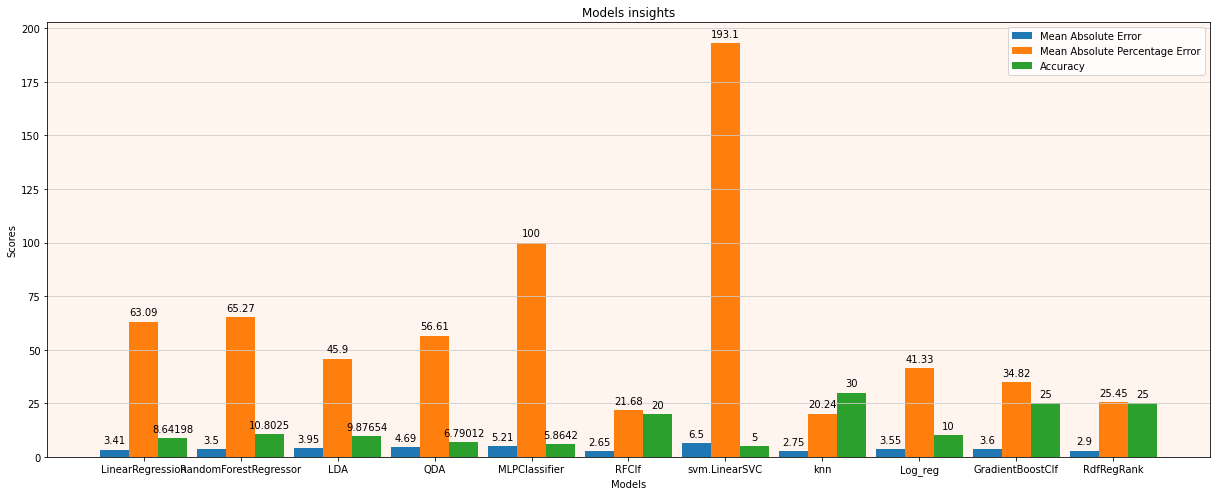

In [90]:
x = np.arange(len(label_))  # the label locations
width = 0.3
fig, ax = plt.subplots(figsize = (17,7))
a1 = ax.bar(x- width,x0,width,label = 'Mean Absolute Error')
a2 = ax.bar(x,x1,width,label = 'Mean Absolute Percentage Error')
a3 = ax.bar(x+ width,x2,width,label = 'Accuracy')
ax.bar_label(a1, padding=4)
ax.bar_label(a2, padding=4)
ax.bar_label(a3, padding=4)
ax.set_title('Accuracy in fonction of the position')
ax.set_ylabel('Mean accuracy in %')
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Models insights')
ax.set_xticks(x, label_)
ax.legend()
plt.grid(axis='y', color='0.8')
ax.set_facecolor('seashell')
plt.tight_layout();

We have the Random forest Classifier and the Knn which can give some good results. The problem with the knn is that it will not always classifie the 20 position but maybe just 6 or 7. Therefore we prefere to stay on the Random Forest Classifier or The Random Forest Regressor with the rank technique applied .

We can see that the results are the best for the Random Forest. Now we have to improve this result

In classification or in regression (+rank), random forest seems to be the best. We'll try to make the classification and the regressio,n work together  

# Test Random Forest with GridSearch 

## Not Scaled 

In [91]:
X_train,y_train,X_test,y_test = test_train_creation_gp(df_features2,2021,10)

In [92]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

### Regression 

In [93]:

n_estimators = [100,200,400,600,800]
max_features = ['auto', 'sqrt']
max_depth = [3,5,10,20,30]
max_depth.append(None)
min_samples_split = [2, 5]
min_samples_leaf = [1, 2]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [94]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 2, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   55.4s finished


RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 10, 20, 30, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200, 400, 600,
                                                         800]},
                   random_state=42, verbose=2)

In [95]:
best_random = rf_random.best_estimator_
best_random

RandomForestRegressor(max_depth=3, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=200)

In [96]:
print('Score on train data:',best_random.score(X_train, y_train))
y_pred = evaluate(best_random, X_test, y_test)

Score on train data: 0.6713696976928499
Mean Absolute Error: 3.99
Mean Absolute Percentage Error : 90.34 %.
Accuracy : 10.0 %.


In [97]:
y_pred

array([ 8.352473  ,  8.46965788,  8.54715229,  7.86981227,  7.9733904 ,
        9.33707905,  8.78395372, 13.12967538,  9.11134204, 12.31136968,
        9.80826049, 12.98913771, 11.73882814, 13.52186314, 10.84832273,
       11.33206659, 14.35266232, 14.59616033,  8.23103235,  8.5724554 ])

In [98]:
y_pred = evaluaterank(y_test,y_pred)

Mean Absolute Error: 4.1
Mean Absolute Percentage Error : 80.79 %.
Accuracy : 10.0 %.


In [99]:
y_pred

[4, 5, 19, 1, 2, 3, 20, 7, 9, 6, 11, 15, 16, 13, 10, 12, 8, 14, 17, 18]

### Classification

In [100]:
param_grid = { 
    'n_estimators': [100,500,800],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,None],
    'criterion' :['gini', 'entropy']
}

In [101]:
rfc=RandomForestClassifier(random_state=42)
CV_rfc = RandomizedSearchCV(estimator = rfc, param_distributions = param_grid, n_iter = 100, cv = 2, verbose=2, random_state=42, n_jobs = -1)
CV_rfc.fit(X_train, y_train)

C:\Users\benja\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 90 is smaller than n_iter=100. Running 90 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 2 folds for each of 90 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.2min finished


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 5, 6, 7, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [100, 500, 800]},
                   random_state=42, verbose=2)

In [102]:
best_randomCV = CV_rfc.best_estimator_
best_random

RandomForestRegressor(max_depth=3, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=200)

In [103]:
print('Score on train data:',best_randomCV.score(X_train, y_train))
y_pred = evaluate(best_randomCV, X_test, y_test)

Score on train data: 0.9944444444444445
Mean Absolute Error: 3.4
Mean Absolute Percentage Error : 37.99 %.
Accuracy : 20.0 %.


In [104]:
y_pred

array([ 3,  4,  3,  4,  7,  8,  6, 12,  8, 10, 10, 14, 12, 12, 12,  5, 18,
       18,  5,  1], dtype=int64)

## Scaled

In [105]:
X_train,y_train,X_test,y_test = test_train_creation_gp(df_scaled2,2021,15)

### Regressor

In [106]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 2, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   53.9s finished


RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 10, 20, 30, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200, 400, 600,
                                                         800]},
                   random_state=42, verbose=2)

In [107]:
best_random = rf_random.best_estimator_
print(best_random)
print('Score on train data:',best_random.score(X_train, y_train))
y_pred = evaluate(best_random, X_test, y_test)
print(y_pred)
y_pred = evaluaterank(y_test,y_pred)
print(y_pred)

RandomForestRegressor(max_depth=3, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=200)
Score on train data: 0.5530203224122479
Mean Absolute Error: 4.06
Mean Absolute Percentage Error : 98.17 %.
Accuracy : 0.0 %.
[ 8.01954512 12.59526917  7.20470661  7.27444449 11.85255321  7.60691359
  7.65000285 11.98877928  7.88318909  7.93183323  7.75936996 10.32297846
 11.10876399  8.01651581 10.60140546 13.59626989 12.07568098 14.37105779
 14.01552221 13.37310168]
Mean Absolute Error: 4.0
Mean Absolute Percentage Error : 58.02 %.
Accuracy : 5.0 %.
[3, 4, 6, 7, 11, 9, 10, 14, 1, 12, 15, 13, 5, 8, 17, 2, 20, 16, 19, 18]


### Classificator 

In [108]:
rfc=RandomForestClassifier(random_state=42)
CV_rfc = RandomizedSearchCV(estimator = rfc, param_distributions = param_grid, n_iter = 100, cv = 2, verbose=2, random_state=42, n_jobs = -1)
CV_rfc.fit(X_train, y_train)

Fitting 2 folds for each of 90 candidates, totalling 180 fits


C:\Users\benja\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 90 is smaller than n_iter=100. Running 90 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.2min finished


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 5, 6, 7, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [100, 500, 800]},
                   random_state=42, verbose=2)

In [109]:
best_randomCV = CV_rfc.best_estimator_
print(best_random)
print('Score on train data:',best_randomCV.score(X_train, y_train))
y_pred = evaluate(best_randomCV, X_test, y_test)
print(y_pred)

RandomForestRegressor(max_depth=3, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=200)
Score on train data: 0.9178571428571428
Mean Absolute Error: 4.0
Mean Absolute Percentage Error : 66.78 %.
Accuracy : 0.0 %.
[ 3 12  4  5  3  7  4 15  5  3  7 10 10  9  8 13 10 16 14 16]


After the analysis of the results, we can observe that the tunning of parameter is not really the good methode.
We have a dataset that changes everytime, so we are not able to find the best parameters. Especially for the begining of the season

The strategie now is to keep the random forest but to decide between the regressor or the classificator one.

We also have to finally decide between the scaled data and the normal ones. 

To do so we'll compare all the possibilities and the results that are possible in our dataset

#### All the possibilities predicted from non scaled data 

In [110]:
year = [2018,2019,2020,2021]
GpNumber = [i for i in range(1,22)]
reg=[]
clf = []
for y in year:
    for g in GpNumber:
        try:

            X_train,y_train,X_test,y_test = test_train_creation_gp(df_features2,y,g)
            random_forest = RandomForestClassifier() 
            model_rd = random_forest.fit(X_train, y_train)

            y_pred = evaluateNoDisplay(random_forest, X_test, y_test)
            clf.append((y_pred,y,g))

            random_forest = RandomForestRegressor()
            model_rd = random_forest.fit(X_train, y_train)
            y_pred,acc = evaluateNoDisplay(random_forest, X_test, y_test)
            l=[]
            l.append((y,g))
            l.append(acc)
            l.append(y_test)
            l.append(y_pred.copy())
            y_pred_2 = evaluaterankNoDisplay(y_test,y_pred)
            l.append(y_pred_2)
            reg.append(l)
        except : 
            print( 'error at:',y,' ',g)
            
            

error at: 2018   1
error at: 2020   18
error at: 2020   19
error at: 2020   20
error at: 2020   21


In [111]:
sum_reg = 0
for i in reg: 
    sum_reg+= i[1][2]
print('Average Accuracy regression without ranking :',sum_reg/len(reg),'%')

Average Accuracy regression without ranking : 7.9113924050632916 %


In [112]:
sum_rank = 0
for i in reg:
    t = i[4]
    c = 0
    for pos in range(0,20):
        if (1+pos)==t[0][pos]:
            c+=1
    sum_rank+=((c/20)*100)
print('Average Accuracy regression with ranking :',sum_rank/len(reg),'%')
        

Average Accuracy regression with ranking : 12.08860759493671 %


In [113]:
clf[:3]

[((array([18,  8, 18, 18, 18, 18, 18,  9, 18, 12, 18, 18, 18, 18, 20, 12, 18,
          18, 18, 18], dtype=int64),
   [6.75, 192.99, 5.0]),
  2018,
  2),
 ((array([14,  2,  1,  2,  6,  6,  7,  1, 11, 14, 15, 16,  8, 14, 14, 14, 14,
           9, 12, 15], dtype=int64),
   [3.55, 92.16, 20.0]),
  2018,
  3),
 ((array([ 2,  3, 12,  8, 11, 19,  7, 14, 13, 19, 16, 18, 16,  2, 16,  5,  1,
          19,  1, 15], dtype=int64),
   [6.55, 79.76, 5.0]),
  2018,
  4)]

When we look at the result of the Classificator, we can see that it is not a logical result for our problem.
Having a regressor allows us to classifie the position of the driver in a better way because the regressor will not give us two times the same result.

We will focus on the regressor

### Now we are also testing on the scaled data.

In [114]:
year = [2018,2019,2020,2021]
GpNumber = [i for i in range(1,22)]
reg_scaled=[]
clf_scaled = []
for y in year:
    for g in GpNumber:
        try:
            X_train,y_train,X_test,y_test = test_train_creation_gp(df_scaled2,y,g)
            random_forest = RandomForestClassifier() 
            model_rd = random_forest.fit(X_train, y_train)

            y_pred = evaluateNoDisplay(random_forest, X_test, y_test)
            clf_scaled.append((y_pred,y,g))

            random_forest = RandomForestRegressor() 
            model_rd = random_forest.fit(X_train, y_train)
            y_pred,acc = evaluateNoDisplay(random_forest, X_test, y_test)
            l=[]
            l.append((y,g))
            l.append(acc)
            l.append(y_test)
            l.append(y_pred.copy())
            y_pred_2 = evaluaterankNoDisplay(y_test,y_pred)
            l.append(y_pred_2)
            reg_scaled.append(l)
        except:
            print( 'error at:',y,' ',g)
            

error at: 2018   1
error at: 2020   18
error at: 2020   19
error at: 2020   20
error at: 2020   21


In [115]:
sum_reg = 0
for i in reg_scaled: 
    sum_reg+= i[1][2]
print('Average Accuracy regression without ranking :',sum_reg/len(reg_scaled),'%')

Average Accuracy regression without ranking : 8.670886075949367 %


In [116]:
sum_rank = 0
for i in reg_scaled:
    t = i[4]
    c = 0
    for pos in range(0,20):
        if (1+pos)==t[0][pos]:
            c+=1
    sum_rank+=((c/20)*100)
print('Average Accuracy regression with ranking :',sum_rank/len(reg_scaled),'%')
        

Average Accuracy regression with ranking : 12.151898734177216 %


##### We should try to find a good random state

In [117]:
year = [2018,2019,2020,2021]
GpNumber = [i for i in range(1,22)]

random_state_result = []
for random in [x for x in range(5,6)]: # between 0 and 100 for testing
    reg_scaled=[]
    for y in year:
        for g in GpNumber:
            try:
                X_train,y_train,X_test,y_test = test_train_creation_gp(df_scaled2,y,g)

                random_forest = RandomForestRegressor(random_state = random) 
                model_rd = random_forest.fit(X_train, y_train)
                y_pred,acc = evaluateNoDisplay(random_forest, X_test, y_test)
                l=[]
                l.append((y,g))
                l.append(acc)
                l.append(y_test)
                l.append(y_pred.copy())
                y_pred_2 = evaluaterankNoDisplay(y_test,y_pred)
                l.append(y_pred_2)
                reg_scaled.append(l)
            except : 
                print( 'error at:',y,' ',g)
                
    print('Random state:',random)      
    sum_reg = 0
    for i in reg_scaled: 
        sum_reg+= i[1][2]
    print('Average Accuracy regression without ranking :',sum_reg/len(reg_scaled),'%')
    sum_rank = 0
    for i in reg_scaled:
        t = i[4]
        c = 0
        for pos in range(0,20):
            if (1+pos)==t[0][pos]:
                c+=1
        sum_rank+=((c/20)*100)
    print('Average Accuracy regression with ranking :',sum_rank/len(reg_scaled),'%')
    print('')
    random_state_result.append([random,sum_reg/len(reg_scaled),sum_rank/len(reg_scaled),reg_scaled])


error at: 2018   1
error at: 2020   18
error at: 2020   19
error at: 2020   20
error at: 2020   21
Random state: 5
Average Accuracy regression without ranking : 8.734177215189874 %
Average Accuracy regression with ranking : 12.531645569620252 %



test made between 0 and 100, best results : Random_state = 9/19/42/43/47!! 47 is the best by far. (12.8 pourcents accuracy)

### After several testing with the supposed best parameters etc, We conclude that the best opportunity to predict the race result is  the Random forest regression with ranking on the scaled data.

In [118]:
year = [2018,2019,2020,2021]
GpNumber = [i for i in range(1,23)]
reg_scaled=[]

for y in year:
    for g in GpNumber:
        try:
            X_train,y_train,X_test,y_test = test_train_creation_gp(df_scaled2,y,g)


            random_forest = RandomForestRegressor(random_state = 47) 
            model_rd = random_forest.fit(X_train, y_train)
            y_pred,acc = evaluateNoDisplay(random_forest, X_test, y_test)
            l=[]
            l.append((y,g))
            l.append(acc)
            l.append(y_test)
            l.append(y_pred.copy())
            y_pred_2 = evaluaterankNoDisplay(y_test,y_pred)
            l.append(y_pred_2)
            reg_scaled.append(l)
        except:
            print( 'error at:',y,' ',g)
            

error at: 2018   1
error at: 2018   22
error at: 2019   22
error at: 2020   18
error at: 2020   19
error at: 2020   20
error at: 2020   21
error at: 2020   22


In [119]:
   
sum_reg = 0
for i in reg_scaled: 
    sum_reg+= i[1][2]
print('Average Accuracy regression without ranking :',sum_reg/len(reg_scaled),'%')
sum_rank = 0
for i in reg_scaled:
    t = i[4]
    c = 0
    if len(t) == 20 :
        for pos in range(0,20):
            if (1+pos)==t[0][pos]:
                c+=1
        sum_rank+=((c/20)*100)
    else : 
        for pos in range(0,19):
            if (1+pos)==t[0][pos]:
                c+=1
        sum_rank+=((c/19)*100)
print('Average Accuracy regression with ranking :',sum_rank/len(reg_scaled),'%')
print('')
random_state_result.append([random,sum_reg/len(reg_scaled),sum_rank/len(reg_scaled),reg_scaled])


Average Accuracy regression without ranking : 8.694078947368421 %
Average Accuracy regression with ranking : 13.223684210526315 %



# Performance study 

We have to understand what the random forest predict and how is it permormant. 

### global Accuracy 

We have an accuracy global of :  this number is calculated by training the model on every possibility of train and test that we can have

This number seems low, but considering all the parameters of the formula one, and also the DNS problem that can occure, this number is good.

This accuracy needs to be compared with other indicators.

### performance within an Interval 

For this insight, we'll considere valide, a position that is +-1 the real position.

In [120]:
def interval_acc(reg_scaled,interval):
    sum_rank = 0
    for i in reg_scaled:
        t = i[4]
        c = 0
        if len(t) == 20 :
            for pos in range(0,20):
                for j in range(0,(interval+1)):
                    if ((1+pos+j)==t[0][pos])|((1+pos-j)==t[0][pos]):
                        c+=1
                        break
            sum_rank+=((c/20)*100)
        else : 
            for pos in range(0,19):
                for j in range(0,(interval+1)):
                    if ((1+pos+j)==t[0][pos])|((1+pos-j)==t[0][pos]):
                        c+=1
                        break
            sum_rank+=((c/19)*100)
    return sum_rank/len(reg_scaled)

In [121]:
print('Interval Accuracy :',interval_acc(reg_scaled,1),'%')

Interval Accuracy : 31.381578947368418 %


Now we have 30 pourcents of success if we classifie the pilot in an interval of 3 places.

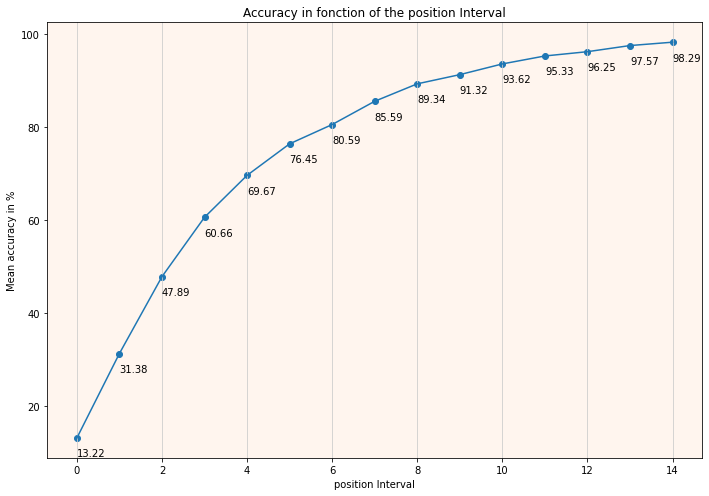

In [122]:
intervals = [interval_acc(reg_scaled,x) for x in range(15)]
x = [x for x in range(15)]
fig, ax = plt.subplots(figsize = (10,7))
ax.scatter(x, intervals)
for i, txt in enumerate([round(j,2) for j in intervals]):
    ax.annotate(txt, (x[i], (intervals[i]-4)))
ax.plot([x for x in range(15)], intervals)
ax.set_title('Accuracy in fonction of the position Interval')
ax.set_ylabel('Mean accuracy in %')
ax.set_xlabel('position Interval')
plt.grid(axis='x', color='0.8')
ax.set_facecolor('seashell')
plt.tight_layout();


Another insight is very good to calculate : The accuracy depending on the position

### The position accuracy

In formula One we want to know who is going to be the first, the middle field or the queue is "less" important. We want to understand if our model can predict the front row the best or not.

In [123]:
def position_acc(reg_scaled,position):
    sum_rank = 0
    for i in reg_scaled:
        t = i[4]
        c = 0  
        if t != reg_scaled[-1][4] :
            if (position==t[0][position-1]):
                c+=1

            sum_rank+=c
        else : 
            position -=1
            if (position==round(t[0][position-1])):
                c=c

            sum_rank+=c
    return (sum_rank/len(reg_scaled))*100

In [124]:
print('Position Accuracy for the Race Winner :',position_acc(reg_scaled,1),'%')

Position Accuracy for the Race Winner : 47.5 %


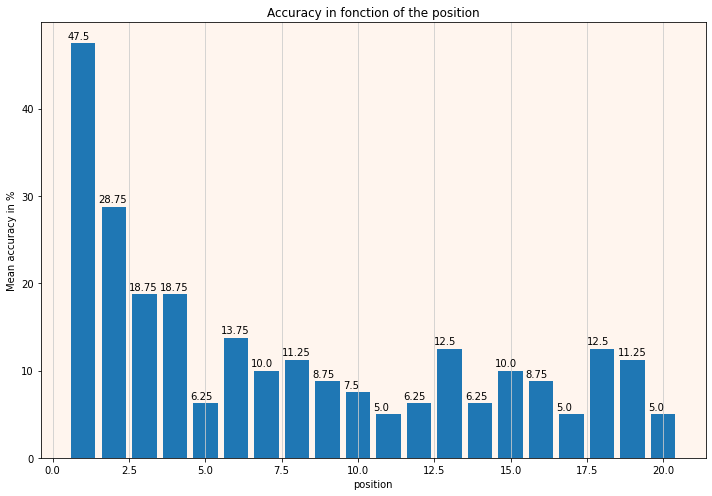

In [125]:
positions_acc = [position_acc(reg_scaled,x) for x in range(1,21)]
x = [x for x in range(1,21)]
fig, ax = plt.subplots(figsize = (10,7))
ax.bar(x, positions_acc)
for i, txt in enumerate([round(j,2) for j in positions_acc]):
    ax.annotate(txt, ((x[i]-0.5), (positions_acc[i]+0.5)))
ax.set_title('Accuracy in fonction of the position')
ax.set_ylabel('Mean accuracy in %')
ax.set_xlabel('position')
plt.grid(axis='x', color='0.8')
ax.set_facecolor('seashell')
plt.tight_layout();

We can observe that our model can make very good predictions concerning the first drivers and the podium

Our model is based on a dataset that get bigger during the season. 
Indeed, the data of the previous Grand Prix are added to feed the Train. In this case,
it is interesting to see the progression of the accuracy depending on the gp Number

### Accuracy evolution during the Season 

In [126]:
def evolution_acc(reg_scaled,gpNumber):
    sum_y = 0
    for y in [2018,2019,2020,2021]:
        sum_rank = 0
        gpn =0
        for i in reg_scaled:
            if (i[0][0] == y)&(i[0][1]<=gpNumber):
                t = i[4]
                c = 0
                gpn+=1
                if len(t) == 20 :
                    for pos in range(0,20):
                        if (1+pos)==t[0][pos]:
                            c+=1
                    sum_rank+=((c/20)*100)
                else:
                    for pos in range(0,19):
                        if (1+pos)==round(t[0][pos]):
                            c+=1
                    sum_rank+=((c/19)*100)
        if gpn!=0:
            sum_y+=sum_rank/gpn
    return sum_y/4

In [127]:
from scipy.interpolate import make_interp_spline

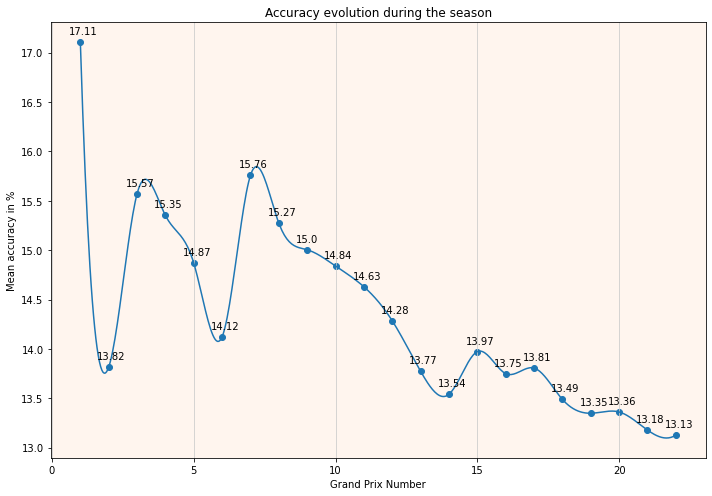

In [128]:

evolutions = [evolution_acc(reg_scaled,x) for x in range(1,23)]
x = np.array([x for x in range(1,23)])

X_Y_Spline = make_interp_spline(x, evolutions)
 
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)

fig, ax = plt.subplots(figsize = (10,7))
ax.scatter(x, evolutions)
for i, txt in enumerate([round(j,2) for j in evolutions]):
    ax.annotate(txt, ((x[i]-0.4), (evolutions[i]+0.08)))
ax.plot(X_, Y_)
ax.set_title('Accuracy evolution during the season')
ax.set_ylabel('Mean accuracy in %')
ax.set_xlabel('Grand Prix Number')
plt.grid(axis='x', color='0.8')
ax.set_facecolor('seashell')
plt.tight_layout();


We can notice from this result that we might have a better accuracy if we change the number of grand prix in count in the train.
We will use the function  test_train_creation_gpV2 to generate our Train

## Modifiying the number of GP in train

In [129]:
def test_deepness(n):
    inter = []
    posacc = []
    evol = []
    for n_ in range(1,n+1):
        print('Results for',n_,'gp considered')
        year = [2018,2019,2020,2021]
        GpNumber = [i for i in range(1,23)]
        reg_scaled=[]

        for y in year:
            for g in GpNumber:
                try:
                    X_train,y_train,X_test,y_test = test_train_creation_gpV2(df_scaled2,y,g,n_)


                    random_forest = RandomForestRegressor(random_state = 47) 
                    model_rd = random_forest.fit(X_train, y_train)
                    y_pred,acc = evaluateNoDisplay(random_forest, X_test, y_test)
                    l=[]
                    l.append((y,g))
                    l.append(acc)
                    l.append(y_test)
                    l.append(y_pred.copy())
                    y_pred_2 = evaluaterankNoDisplay(y_test,y_pred)
                    l.append(y_pred_2)
                    reg_scaled.append(l)
                except:
                    error = 0
                    #print( 'error at:',y,' ',g)
        sum_reg = 0
        for i in reg_scaled: 
            sum_reg+= i[1][2]
        print('Average Accuracy regression without ranking :',sum_reg/len(reg_scaled),'%')
        sum_rank = 0
        for i in reg_scaled:
            t = i[4]
            c = 0
            if len(t) == 20 :
                for pos in range(0,20):
                    if (1+pos)==t[0][pos]:
                        c+=1
                sum_rank+=((c/20)*100)
            else : 
                for pos in range(0,19):
                    if (1+pos)==t[0][pos]:
                        c+=1
                sum_rank+=((c/19)*100)
        print('Average Accuracy regression with ranking :',sum_rank/len(reg_scaled),'%')
        print('')
        
        intervals = [interval_acc(reg_scaled,x) for x in range(15)]
        positions_acc = [position_acc(reg_scaled,x) for x in range(1,21)]
        evolutions = [evolution_acc(reg_scaled,x) for x in range(1,23)]
        inter.append(intervals)
        posacc.append(positions_acc)
        evol.append(evolutions)
        
    x = [x for x in range(15)]
    fig, ax = plt.subplots(figsize = (12,9))
    c=1
    for elmt in inter:
        ax.scatter(x, elmt)
        ax.plot([x for x in range(15)], elmt,label = c )
        c+=1
    ax.set_title('Accuracy in fonction of the position Interval')
    ax.set_ylabel('Mean accuracy in %')
    ax.set_xlabel('position Interval')
    plt.grid(axis='x', color='0.8')
    ax.set_facecolor('seashell')
    ax.legend()
    plt.tight_layout();
    
    
    x = [x for x in range(1,21)]
    fig, ax = plt.subplots(figsize = (12,9))
    c=1
    for elmt in posacc:
        ax.plot(x, elmt,label = c )
        c+=1
    ax.set_title('Accuracy in fonction of the position')
    ax.set_ylabel('Mean accuracy in %')
    ax.set_xlabel('position')
    plt.grid(axis='x', color='0.8')
    ax.set_facecolor('seashell')
    ax.legend()
    plt.tight_layout();
    
    
    x = np.array([x for x in range(1,23)])
    fig, ax = plt.subplots(figsize = (12,9))
    c=1
    for elmt in evol:
        X_Y_Spline = make_interp_spline(x, elmt)
        X_ = np.linspace(x.min(), x.max(), 500)
        Y_ = X_Y_Spline(X_)
        ax.scatter(x, elmt)
        ax.plot(X_, Y_,label = c )
        c+=1
    ax.set_title('Accuracy evolution during the season')
    ax.set_ylabel('Mean accuracy in %')
    ax.set_xlabel('Grand Prix Number')
    plt.grid(axis='x', color='0.8')
    ax.legend()
    ax.set_facecolor('seashell')
    plt.tight_layout();

In [130]:
def test_deepness_Unique(n):
    print('Results for ',n,'gp considered')
    year = [2018,2019,2020,2021]
    GpNumber = [i for i in range(1,23)]
    reg_scaled=[]

    for y in year:
        for g in GpNumber:
            try:
                X_train,y_train,X_test,y_test = test_train_creation_gpV2(df_scaled2,y,g,n)


                random_forest = RandomForestRegressor(random_state = 47) 
                model_rd = random_forest.fit(X_train, y_train)
                y_pred,acc = evaluateNoDisplay(random_forest, X_test, y_test)
                l=[]
                l.append((y,g))
                l.append(acc)
                l.append(y_test)
                l.append(y_pred.copy())
                y_pred_2 = evaluaterankNoDisplay(y_test,y_pred)
                l.append(y_pred_2)
                reg_scaled.append(l)
            except:
                print( 'error at:',y,' ',g)
    sum_reg = 0
    for i in reg_scaled: 
        sum_reg+= i[1][2]
    print('Average Accuracy regression without ranking :',sum_reg/len(reg_scaled),'%')
    sum_rank = 0
    for i in reg_scaled:
        t = i[4]
        c = 0
        if len(t) == 20 :
            for pos in range(0,20):
                if (1+pos)==t[0][pos]:
                    c+=1
            sum_rank+=((c/20)*100)
        else : 
            for pos in range(0,19):
                if (1+pos)==t[0][pos]:
                    c+=1
            sum_rank+=((c/19)*100)
    print('Average Accuracy regression with ranking :',sum_rank/len(reg_scaled),'%')
    print('')
    intervals = [interval_acc(reg_scaled,x) for x in range(15)]
    x = [x for x in range(15)]
    fig, ax = plt.subplots(figsize = (10,7))
    ax.scatter(x, intervals)
    for i, txt in enumerate([round(j,2) for j in intervals]):
        ax.annotate(txt, (x[i], (intervals[i]-4)))
    ax.plot([x for x in range(15)], intervals)
    ax.set_title('Accuracy in fonction of the position Interval')
    ax.set_ylabel('Mean accuracy in %')
    ax.set_xlabel('position Interval')
    plt.grid(axis='x', color='0.8')
    ax.set_facecolor('seashell')
    plt.tight_layout();
    
    positions_acc = [position_acc(reg_scaled,x) for x in range(1,21)]
    x = [x for x in range(1,21)]
    fig, ax = plt.subplots(figsize = (10,7))
    ax.bar(x, positions_acc)
    for i, txt in enumerate([round(j,2) for j in positions_acc]):
        ax.annotate(txt, ((x[i]-0.5), (positions_acc[i]+0.5)))
    ax.set_title('Accuracy in fonction of the position')
    ax.set_ylabel('Mean accuracy in %')
    ax.set_xlabel('position')
    plt.grid(axis='x', color='0.8')
    ax.set_facecolor('seashell')
    plt.tight_layout();
    evolutions = [evolution_acc(reg_scaled,x) for x in range(1,23)]
    x = np.array([x for x in range(1,23)])

    X_Y_Spline = make_interp_spline(x, evolutions)

    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_)

    fig, ax = plt.subplots(figsize = (10,7))
    ax.scatter(x, evolutions)
    for i, txt in enumerate([round(j,2) for j in evolutions]):
        ax.annotate(txt, ((x[i]-0.4), (evolutions[i]+0.08)))
    ax.plot(X_, Y_)
    ax.set_title('Accuracy evolution during the season')
    ax.set_ylabel('Mean accuracy in %')
    ax.set_xlabel('Grand Prix Number')
    plt.grid(axis='x', color='0.8')
    ax.set_facecolor('seashell')
    plt.tight_layout();

Those functions help you see wich of the parameters n (number of gp take in account in the train) might be the best.

In [131]:
test_deepness(19)

NameError: name 'test_deepnesas' is not defined

The 17 gives good stability over the differents grand prix, also it gives a good estimation of the podium and one of the best interval precision.

# The best one is with the parameter n=17 

# Conclusion 

### We are finally using a Random Forest Regressor with a random state of 47, with an transformation of the output call Ranking. 
### Because of the nature of our problem, we have to train that model for every new prediction.
### Another parameter is N, the number of GP in counting in the computation of the train. 
### Here n=17
### We are also using scaled data (cf: df_scaled2) 

Bellow, the final results 

In [ ]:
test_deepness_Unique(17)

In [ ]:
def test_deepness_Unique_graph(n):
    year = [2018,2019,2020,2021]
    GpNumber = [i for i in range(1,23)]
    reg_scaled=[]
    interval_acc=[]
    position_acc=[]
    evolution_acc = []
    
    for y in year:
        for g in GpNumber:
            try:
                X_train,y_train,X_test,y_test = test_train_creation_gpV2(df_scaled2,y,g,n)


                random_forest = RandomForestRegressor(random_state = 47) 
                model_rd = random_forest.fit(X_train, y_train)
                y_pred,acc = evaluateNoDisplay(random_forest, X_test, y_test)
                l=[]
                l.append((y,g))
                l.append(acc)
                l.append(y_test)
                l.append(y_pred.copy())
                y_pred_2 = evaluaterankNoDisplay(y_test,y_pred)
                l.append(y_pred_2)
                reg_scaled.append(l)
            except:
                error = 0

                
    intervals = [interval_acc(reg_scaled,x) for x in range(15)]
    x = [x for x in range(15)]
    fig, ax = plt.subplots(figsize = (10,7))
    ax.scatter(x, intervals)
    for i, txt in enumerate([round(j,2) for j in intervals]):
        ax.annotate(txt, (x[i], (intervals[i]-4)))
    ax.plot([x for x in range(15)], intervals)
    ax.set_title('Accuracy in fonction of the position Interval')
    ax.set_ylabel('Mean accuracy in %')
    ax.set_xlabel('position Interval')
    plt.grid(axis='x', color='0.8')
    ax.set_facecolor('seashell')
    plt.tight_layout();
    
    positions_acc = [position_acc(reg_scaled,x) for x in range(1,21)]
    x = [x for x in range(1,21)]
    fig, ax = plt.subplots(figsize = (10,7))
    ax.bar(x, positions_acc)
    for i, txt in enumerate([round(j,2) for j in positions_acc]):
        ax.annotate(txt, ((x[i]-0.5), (positions_acc[i]+0.5)))
    ax.set_title('Accuracy in fonction of the position')
    ax.set_ylabel('Mean accuracy in %')
    ax.set_xlabel('position')
    plt.grid(axis='x', color='0.8')
    ax.set_facecolor('seashell')
    plt.tight_layout();
    
    evolutions = [evolution_acc(reg_scaled,x) for x in range(1,23)]
    x = np.array([x for x in range(1,23)])

    X_Y_Spline = make_interp_spline(x, evolutions)

    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_)

    fig, ax = plt.subplots(figsize = (10,7))
    ax.scatter(x, evolutions)
    for i, txt in enumerate([round(j,2) for j in evolutions]):
        ax.annotate(txt, ((x[i]-0.4), (evolutions[i]+0.08)))
    ax.plot(X_, Y_)
    ax.set_title('Accuracy evolution during the season')
    ax.set_ylabel('Mean accuracy in %')
    ax.set_xlabel('Grand Prix Number')
    plt.grid(axis='x', color='0.8')
    ax.set_facecolor('seashell')
    plt.tight_layout();

In [ ]:
    intervals = [interval_acc(reg_scaled,x) for x in range(15)]
    x = [x for x in range(15)]
    fig, ax = plt.subplots(figsize = (10,7))
    ax.scatter(x, intervals)
    for i, txt in enumerate([round(j,2) for j in intervals]):
        ax.annotate(txt, (x[i], (intervals[i]-4)))
    ax.plot([x for x in range(15)], intervals)
    ax.set_title('Accuracy in fonction of the position Interval')
    ax.set_ylabel('Mean accuracy in %')
    ax.set_xlabel('position Interval')
    plt.grid(axis='x', color='0.8')
    ax.set_facecolor('seashell')
    plt.tight_layout();

fig = px.scatter(df, x=x, y=intervals, text="country", log_x=True, size_max=60)

fig.update_traces(textposition='top center')
fig.add_trace(
    go.Scatter(
        x=[2, 4],
        y=[4, 8],
        mode="lines",
        line=go.scatter.Line(color="gray"),
        showlegend=False)
fig.update_layout(
    height=800,
    title_text='GDP and Life Expectancy (Americas, 2007)'
)

fig.show()

In [133]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
fig = px.scatter(df, x="sepal_width", y="sepal_length", color="species",
                 title="Using The add_trace() method With A Plotly Express Figure")
)
fig.show()

In [185]:
x = [x for x in range(15)]
a = pd.DataFrame(x, columns = ['position Interval'])
a['Mean accuracy in %'] = intervals
a['Accuracy'] = [round(j,2) for j in intervals]
a['c'] = ["Performance" for x in range(15)]
fig = px.line(  a,x='position Interval', y='Mean accuracy in %', text='Accuracy',template = 'plotly_dark',color = 'c',color_discrete_sequence = ['darkred'])
fig.update_traces(textposition='top center')
fig.update_layout(title = "Accuracy in fonction of the position Interval")
fig.show()

In [190]:
x = [x for x in range(1,21)]
positions_acc = [position_acc(reg_scaled,x) for x in range(1,21)]
a = pd.DataFrame(x, columns = ['position'])
a['Mean accuracy in %'] = positions_acc
a['Accuracy'] = [round(j,2) for j in positions_acc]
a['c'] = ["Performance" for x in range(1,21)]

fig = px.bar(  a,x='position', y='Mean accuracy in %', text='Accuracy',template = 'plotly_dark',color = 'c',color_discrete_sequence = ['darkred'])
fig.update_layout(title = "Accuracy in fonction of the position")
fig.show()





In [220]:
evolutions = [evolution_acc(reg_scaled,x) for x in range(1,23)]
x = np.array([x for x in range(1,23)])
X_Y_Spline = make_interp_spline(x, evolutions)

X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)

a = pd.DataFrame(X_, columns = ['X_'])
#a['Mean accuracy in %'] = evolutions
acc_ = [round(j,2) for j in evolutions]
acc= []
ca = 0
for i in range(500):
    if i%23 == 0 & i!= 500:
        
        acc.append(acc_[ca])
        ca+=1
    else:
        acc.append(None)
a['c'] = ["Performance" for x in range(500)]
a['Grand Prix Number'] = X_
a['Mean accuracy in %'] = Y_
a['Accuracy'] = acc
fig = px.line(  a,x='Grand Prix Number', y='Mean accuracy in %',template = 'plotly_dark',text='Accuracy',color = 'c',color_discrete_sequence = ['darkred'])
fig.update_traces(textposition='middle center')
fig.update_layout(title = "Accuracy evolution during the season")
fig.show()

